<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Image%20Classification/Transfer_learning_for_Image_classification_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt

## Download the dataset

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

dataset = tf.keras.utils.get_file('cats_and_dogs', URL, extract=True, cache_dir='.', cache_subdir='')

68608000/68606236 [==============================] - 1s 0us/step


In [3]:
parent_dir = pathlib.Path(dataset).parent
print('Parent directory : ',parent_dir)
print('\n'.join(['Sub directory : '+str(dir) for dir in parent_dir.iterdir()]))

cats_and_dogs = parent_dir/'cats_and_dogs_filtered'

print('\n'.join(['Work directory : '+str(dir) for dir in cats_and_dogs.iterdir()]))

train_dir = cats_and_dogs/'train'
val_dir = cats_and_dogs/'validation'

Parent directory :  .
Sub directory : .config
Sub directory : cats_and_dogs_filtered
Sub directory : cats_and_dogs
Sub directory : sample_data
Work directory : cats_and_dogs_filtered/validation
Work directory : cats_and_dogs_filtered/vectorize.py
Work directory : cats_and_dogs_filtered/train


In [4]:
# create train, validation and test directory

raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=(160,160), batch_size=32, shuffle=True)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=(160,160), batch_size=32, shuffle=True)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
print('Number of Batched in Validation set',raw_val_ds.cardinality().numpy())
print('Create test set from validation set')
raw_test_ds = raw_val_ds.take(32//5)
raw_val_ds = raw_val_ds.skip(32//5)
print('Number of Batched in Validation set',raw_val_ds.cardinality().numpy())
print('Number of Batched in Test set',raw_test_ds.cardinality().numpy())

Number of Batched in Validation set 32
Create test set from validation set
Number of Batched in Validation set 26
Number of Batched in Test set 6


## Optimize for performance

In [6]:
# create buffered prefetch
train_ds = raw_train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = raw_val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = raw_test_ds.prefetch(tf.data.AUTOTUNE)

## Data augmentation

In [7]:
random_flip = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')
random_rotation = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1)

data_augmentation = tf.keras.Sequential([random_flip, random_rotation])

## Rescaling

In [8]:
# we can use the preprocess_input method that comes with the model or create a rescaling layer
resale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/127.5, offset=-1)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Global average pooling 

In [9]:
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()

## Classification layer

In [10]:
prediction_layer = tf.keras.layers.Dense(1)

## Convolutional base : MobileNetV2

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3), include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
# freeze the convolution base
base_model.trainable = False

### Build a model 

In [13]:
# input
inputs = tf.keras.Input(shape=(160,160,3))
# data-augmentation
x = data_augmentation(inputs)
# preprocessing 
x = preprocess_input(x)
# mobile net v2 -- inference mode
x = base_model(x, training=False)
# global average pooling
x = global_avg_pool(x)
# drop-out
x = tf.keras.layers.Dropout(0.2)(x)
# classification
outputs = prediction_layer(x)

mobile_net_model = tf.keras.Model(inputs, outputs)

### Compile the model

In [14]:
# compile
mobile_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=['accuracy'])

In [15]:
mobile_net_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

### Model Training

In [16]:
history = mobile_net_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
63/63 [==============================] - 55s 812ms/step - loss: 0.6988 - accuracy: 0.5870 - val_loss: 0.5126 - val_accuracy: 0.7104
Epoch 2/10
63/63 [==============================] - 49s 782ms/step - loss: 0.5773 - accuracy: 0.6845 - val_loss: 0.3990 - val_accuracy: 0.7933
Epoch 3/10
63/63 [==============================] - 50s 798ms/step - loss: 0.4973 - accuracy: 0.7435 - val_loss: 0.3192 - val_accuracy: 0.8478
Epoch 4/10
63/63 [==============================] - 50s 789ms/step - loss: 0.4249 - accuracy: 0.7835 - val_loss: 0.2685 - val_accuracy: 0.8787
Epoch 5/10
63/63 [==============================] - 50s 798ms/step - loss: 0.3801 - accuracy: 0.8090 - val_loss: 0.2342 - val_accuracy: 0.8985
Epoch 6/10
63/63 [==============================] - 51s 808ms/step - loss: 0.3455 - accuracy: 0.8415 - val_loss: 0.2061 - val_accuracy: 0.9146
Epoch 7/10
63/63 [==============================] - 51s 809ms/step - loss: 0.3335 - accuracy: 0.8470 - val_loss: 0.1856 - val_accuracy: 0.9344

### Evaluation

In [17]:
loss, accuracy = mobile_net_model.evaluate(test_ds)
print('Loss', loss)
print('Accuracy', accuracy)

6/6 [==============================] - 4s 575ms/step - loss: 0.1760 - accuracy: 0.9323
Loss 0.17604148387908936
Accuracy 0.9322916865348816


### Fine tuning the model

In [18]:
# unfreeze the pre-trained model
base_model.trainable = True

In [19]:
print('Number of layers in Pre-trained model', len(base_model.layers))

Number of layers in Pre-trained model 154


In [20]:
# set the bottom layers to be un-trainable
fine_tune = 100

for layer in base_model.layers[:fine_tune]:
  layer.trainable = False

### Compile the model

In [21]:
mobile_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                         loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=['accuracy'])

In [22]:
mobile_net_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

### Training -- fine tuning

In [23]:
fine_tune_history = mobile_net_model.fit(train_ds, epochs=20, initial_epoch=history.epoch[-1], validation_data=val_ds)

Epoch 10/20
63/63 [==============================] - 82s 1s/step - loss: 0.2174 - accuracy: 0.9100 - val_loss: 0.0711 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 76s 1s/step - loss: 0.1689 - accuracy: 0.9325 - val_loss: 0.0683 - val_accuracy: 0.9740
Epoch 12/20
63/63 [==============================] - 76s 1s/step - loss: 0.1363 - accuracy: 0.9415 - val_loss: 0.0497 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 76s 1s/step - loss: 0.1328 - accuracy: 0.9475 - val_loss: 0.0560 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 74s 1s/step - loss: 0.1204 - accuracy: 0.9510 - val_loss: 0.0506 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 75s 1s/step - loss: 0.1036 - accuracy: 0.9575 - val_loss: 0.0481 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 74s 1s/step - loss: 0.1218 - accuracy: 0.9530 - val_loss: 0.0461 - val_accuracy: 0.9864
Epoch 17/20
6

### Evaluation

In [24]:
loss, accuracy = mobile_net_model.evaluate(test_ds)
print('Loss', loss)
print('Accuracy', accuracy)

6/6 [==============================] - 3s 519ms/step - loss: 0.0425 - accuracy: 0.9844
Loss 0.04253436625003815
Accuracy 0.984375


### Learning curves

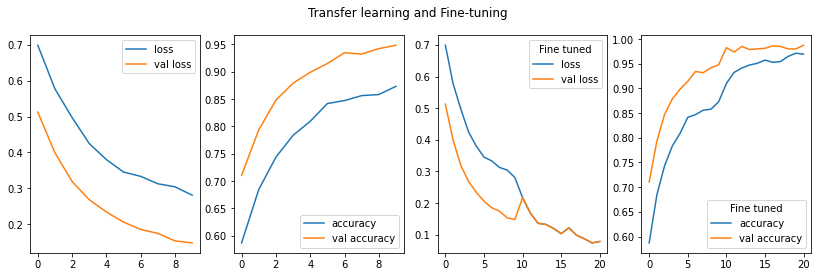

In [59]:
# model before fine tuning
plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(range(10), history.history['loss'], label='loss')
plt.plot(range(10), history.history['val_loss'], label='val loss')
plt.legend()
plt.subplot(1,4,2)
plt.plot(range(10), history.history['accuracy'], label='accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='val accuracy')
plt.legend()
# model after fine tuning
plt.subplot(1,4,3)
plt.plot(range(21), (history.history['loss']+fine_tune_history.history['loss']), label='loss')
plt.plot(range(21), (history.history['val_loss']+fine_tune_history.history['loss']), label='val loss')
plt.legend(title='Fine tuned')
plt.subplot(1,4,4)
plt.plot(range(21), (history.history['accuracy']+fine_tune_history.history['accuracy']), label='accuracy')
plt.plot(range(21), (history.history['val_accuracy']+fine_tune_history.history['val_accuracy']), label='val accuracy')
plt.legend(title='Fine tuned')


plt.suptitle('Transfer learning and Fine-tuning')

plt.show()

## Convolution base Xception

In [60]:
conv_base = tf.keras.applications.Xception(include_top=False,
                                           weights='imagenet',
                                           input_shape=(160,160,3))

83689472/83683744 [==============================] - 1s 0us/step


In [67]:
# freeze the pretrained model
conv_base.trainable = False

In [68]:
# we can use the preprocess_input method that comes with the model for rescaling  
conv_preprocess = tf.keras.applications.xception.preprocess_input

### Build a model

In [69]:
# input layer
inputs = tf.keras.layers.Input(shape=(160,160,3))
# data-augmentation
x = data_augmentation(inputs)
# preprocessing
x = conv_preprocess(x)
# xception model -- inference mode
x = conv_base(x, training=False)
# global-average-pooling
x = global_avg_pool(x)
# dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# classification layer
outputs = tf.keras.layers.Dense(1)(x)

xception_model = tf.keras.Model(inputs, outputs)

### Compile the model

In [70]:
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [71]:
xception_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0   

In [72]:
# Early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

### Model training

In [73]:
xception_history = xception_model.fit(train_ds,
                                      epochs=10,
                                      validation_data=val_ds,
                                      callbacks=[early_stopping])

Epoch 1/10
63/63 [==============================] - 269s 4s/step - loss: 0.6454 - accuracy: 0.6175 - val_loss: 0.4777 - val_accuracy: 0.7958
Epoch 2/10
63/63 [==============================] - 264s 4s/step - loss: 0.5055 - accuracy: 0.7490 - val_loss: 0.3354 - val_accuracy: 0.8762
Epoch 3/10
63/63 [==============================] - 264s 4s/step - loss: 0.4182 - accuracy: 0.8085 - val_loss: 0.2599 - val_accuracy: 0.9171
Epoch 4/10
63/63 [==============================] - 264s 4s/step - loss: 0.3766 - accuracy: 0.8260 - val_loss: 0.2199 - val_accuracy: 0.9295
Epoch 5/10
63/63 [==============================] - 263s 4s/step - loss: 0.3414 - accuracy: 0.8535 - val_loss: 0.1883 - val_accuracy: 0.9443
Epoch 6/10
63/63 [==============================] - 262s 4s/step - loss: 0.3279 - accuracy: 0.8505 - val_loss: 0.1660 - val_accuracy: 0.9530
Epoch 7/10
63/63 [==============================] - 263s 4s/step - loss: 0.2990 - accuracy: 0.8680 - val_loss: 0.1511 - val_accuracy: 0.9517
Epoch 8/10
63

### Evaluation

In [74]:
loss, accuracy = xception_model.evaluate(test_ds)
print('Loss', loss)
print('Accuracy', accuracy)

6/6 [==============================] - 18s 3s/step - loss: 0.1391 - accuracy: 0.9479
Loss 0.13907913863658905
Accuracy 0.9479166865348816


### Fine tuning

In [77]:
# unfreeze the pre-trained model
conv_base.trainable = True

print('Number of layers in Xception model',len(conv_base.layers))

Number of layers in Xception model 132


In [78]:
# we only want the top layers to adapt not the whole pre-trained model
fine_tune = 100
for layer in conv_base.layers[:fine_tune]:
  layer.trainable = False

### Compile the model

In [79]:
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [80]:
xception_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0   

In [81]:
xception_fine_tune_history = xception_model.fit(train_ds,
                                                epochs=20,
                                                validation_data=val_ds,
                                                initial_epoch=xception_history.epoch[-1],
                                                callbacks=[early_stopping])

Epoch 10/20
63/63 [==============================] - 406s 6s/step - loss: 0.2576 - accuracy: 0.8805 - val_loss: 0.0894 - val_accuracy: 0.9604
Epoch 11/20
63/63 [==============================] - 405s 6s/step - loss: 0.2082 - accuracy: 0.9090 - val_loss: 0.0741 - val_accuracy: 0.9629
Epoch 12/20
63/63 [==============================] - 404s 6s/step - loss: 0.1760 - accuracy: 0.9295 - val_loss: 0.0635 - val_accuracy: 0.9703
Epoch 13/20
63/63 [==============================] - 403s 6s/step - loss: 0.1493 - accuracy: 0.9365 - val_loss: 0.0667 - val_accuracy: 0.9678


In [82]:
loss, accuracy = xception_model.evaluate(test_ds)
print('Loss', loss)
print('Accuracy', accuracy)

6/6 [==============================] - 18s 3s/step - loss: 0.0932 - accuracy: 0.9427
Loss 0.09321192651987076
Accuracy 0.9427083134651184


### Learning curves

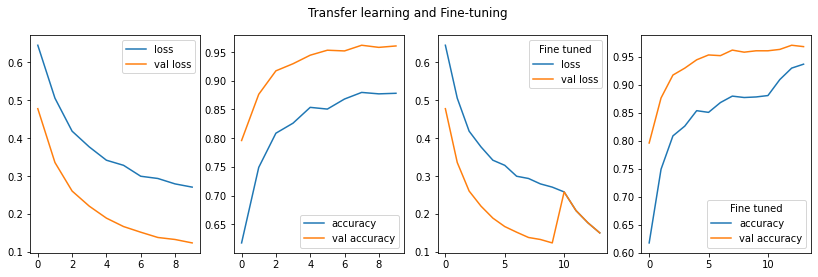

In [85]:
# model before fine tuning
plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(range(10), xception_history.history['loss'], label='loss')
plt.plot(range(10), xception_history.history['val_loss'], label='val loss')
plt.legend()
plt.subplot(1,4,2)
plt.plot(range(10), xception_history.history['accuracy'], label='accuracy')
plt.plot(range(10), xception_history.history['val_accuracy'], label='val accuracy')
plt.legend()
# model after fine tuning
plt.subplot(1,4,3)
plt.plot(range(14), (xception_history.history['loss']+xception_fine_tune_history.history['loss']), label='loss')
plt.plot(range(14), (xception_history.history['val_loss']+xception_fine_tune_history.history['loss']), label='val loss')
plt.legend(title='Fine tuned')
plt.subplot(1,4,4)
plt.plot(range(14), (xception_history.history['accuracy']+xception_fine_tune_history.history['accuracy']), label='accuracy')
plt.plot(range(14), (xception_history.history['val_accuracy']+xception_fine_tune_history.history['val_accuracy']), label='val accuracy')
plt.legend(title='Fine tuned')


plt.suptitle('Transfer learning and Fine-tuning')

plt.show()